#### **Importing Libraries**


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    LabelEncoder,
    RobustScaler,
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


import warnings

warnings.filterwarnings("ignore")

#### **Setup Pandas Display Option**


In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.width", 500)

##### Importing Dataset


In [3]:
df = pd.read_csv("diabetes_data.csv")

##### Exploring the dataset


In [4]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1
5,5,116,74,0,0,25.600,0.201,30,0
6,3,78,50,32,88,31.000,0.248,26,1
7,10,115,0,0,0,35.300,0.134,29,0
8,2,197,70,45,543,30.500,0.158,53,1
9,8,125,96,0,0,0.000,0.232,54,1


In [5]:
def check_df(dataframe, head=5):
    print("SHAPE".center(70, "-"))
    print(dataframe.shape)
    print("INFO".center(70, "-"))
    print(dataframe.info())
    print("MISSING VALUES".center(70, "-"))
    print(dataframe.isnull().sum())
    print("DUPLICATED VALUES".center(70, "-"))
    print(dataframe.duplicated().sum())


check_df(df)

--------------------------------SHAPE---------------------------------
(768, 9)
---------------------------------INFO---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
----------------------------MISSING VALUES----------------------------
Pregnancies  

In [6]:
percentiles = [0.10, 0.25, 0.80, 0.90, 0.95, 0.99]
df.describe(percentiles=percentiles).T

,count,mean,std,min,10%,25%,50%,80%,90%,95%,99%,max
Pregnancies,768.000,3.845,3.370,0.000,0.000,1.000,3.000,7.000,9.000,10.000,13.000,17.000
Glucose,768.000,120.895,31.973,0.000,85.000,99.000,117.000,147.000,167.000,181.000,196.000,199.000
BloodPressure,768.000,69.105,19.356,0.000,54.000,62.000,72.000,82.000,88.000,90.000,106.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,0.000,23.000,35.000,40.000,44.000,51.330,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,0.000,30.500,150.000,210.000,293.000,519.900,846.000
BMI,768.000,31.993,7.884,0.000,23.600,27.300,32.000,37.800,41.500,44.395,50.759,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.165,0.244,0.372,0.687,0.879,1.133,1.698,2.420
Age,768.000,33.241,11.760,21.000,22.000,24.000,29.000,42.600,51.000,58.000,67.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000


In [7]:
# Since Glucose, BloodPressure, SkinThickness, Insulin, and BMI canot be zero we need to treat them as missing values

variables_to_replace = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df[variables_to_replace] = df[variables_to_replace].replace(0, np.nan)

#### **Breaking the dataframe into categorical and numerical columns**


In [8]:
cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
num_but_cat = [
    col for col in df.columns if df[col].nunique() < 10 and df[col].dtypes != "O"
]
cat_but_car = [
    col for col in df.columns if df[col].nunique() > 10 and df[col].dtypes == "O"
]
cat_cols = cat_cols + num_but_cat
cat_cols = [col for col in cat_cols if col not in cat_but_car]

# num_cols
num_cols = [col for col in df.columns if df[col].dtypes != "O"]
num_cols = [col for col in num_cols if col not in num_but_cat]

#### **Checking the correlation among numberial columns**


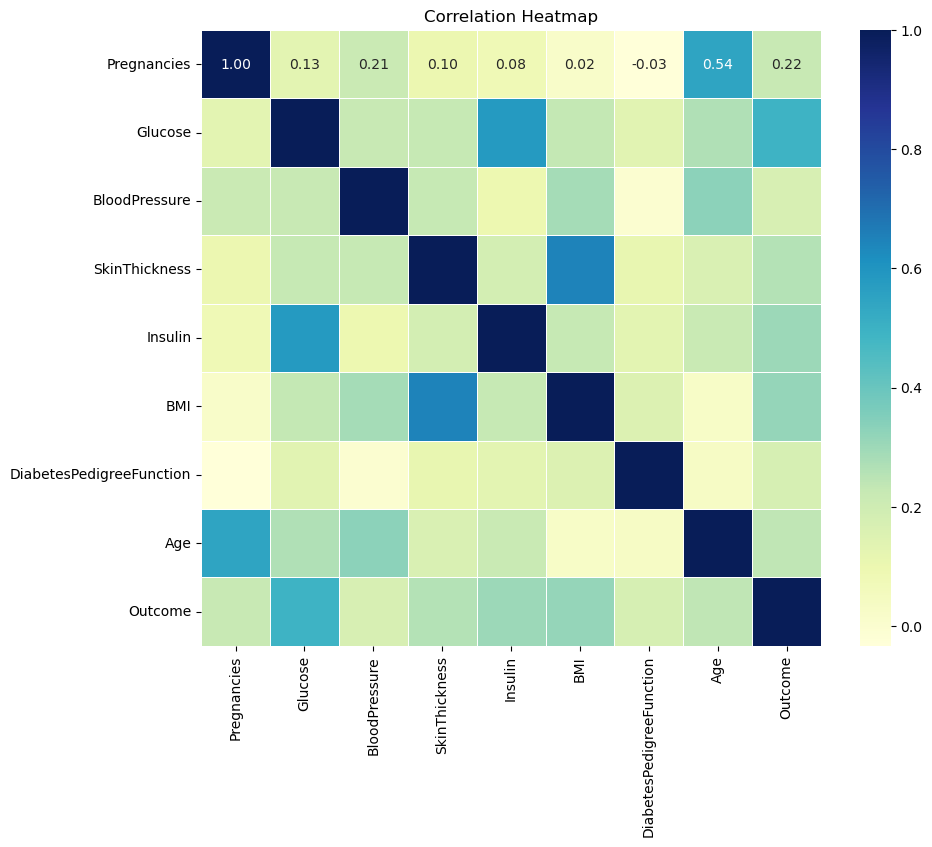

In [9]:
corr_matrix = df.corr()

# Create Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

#### **Vizualizing the Data**


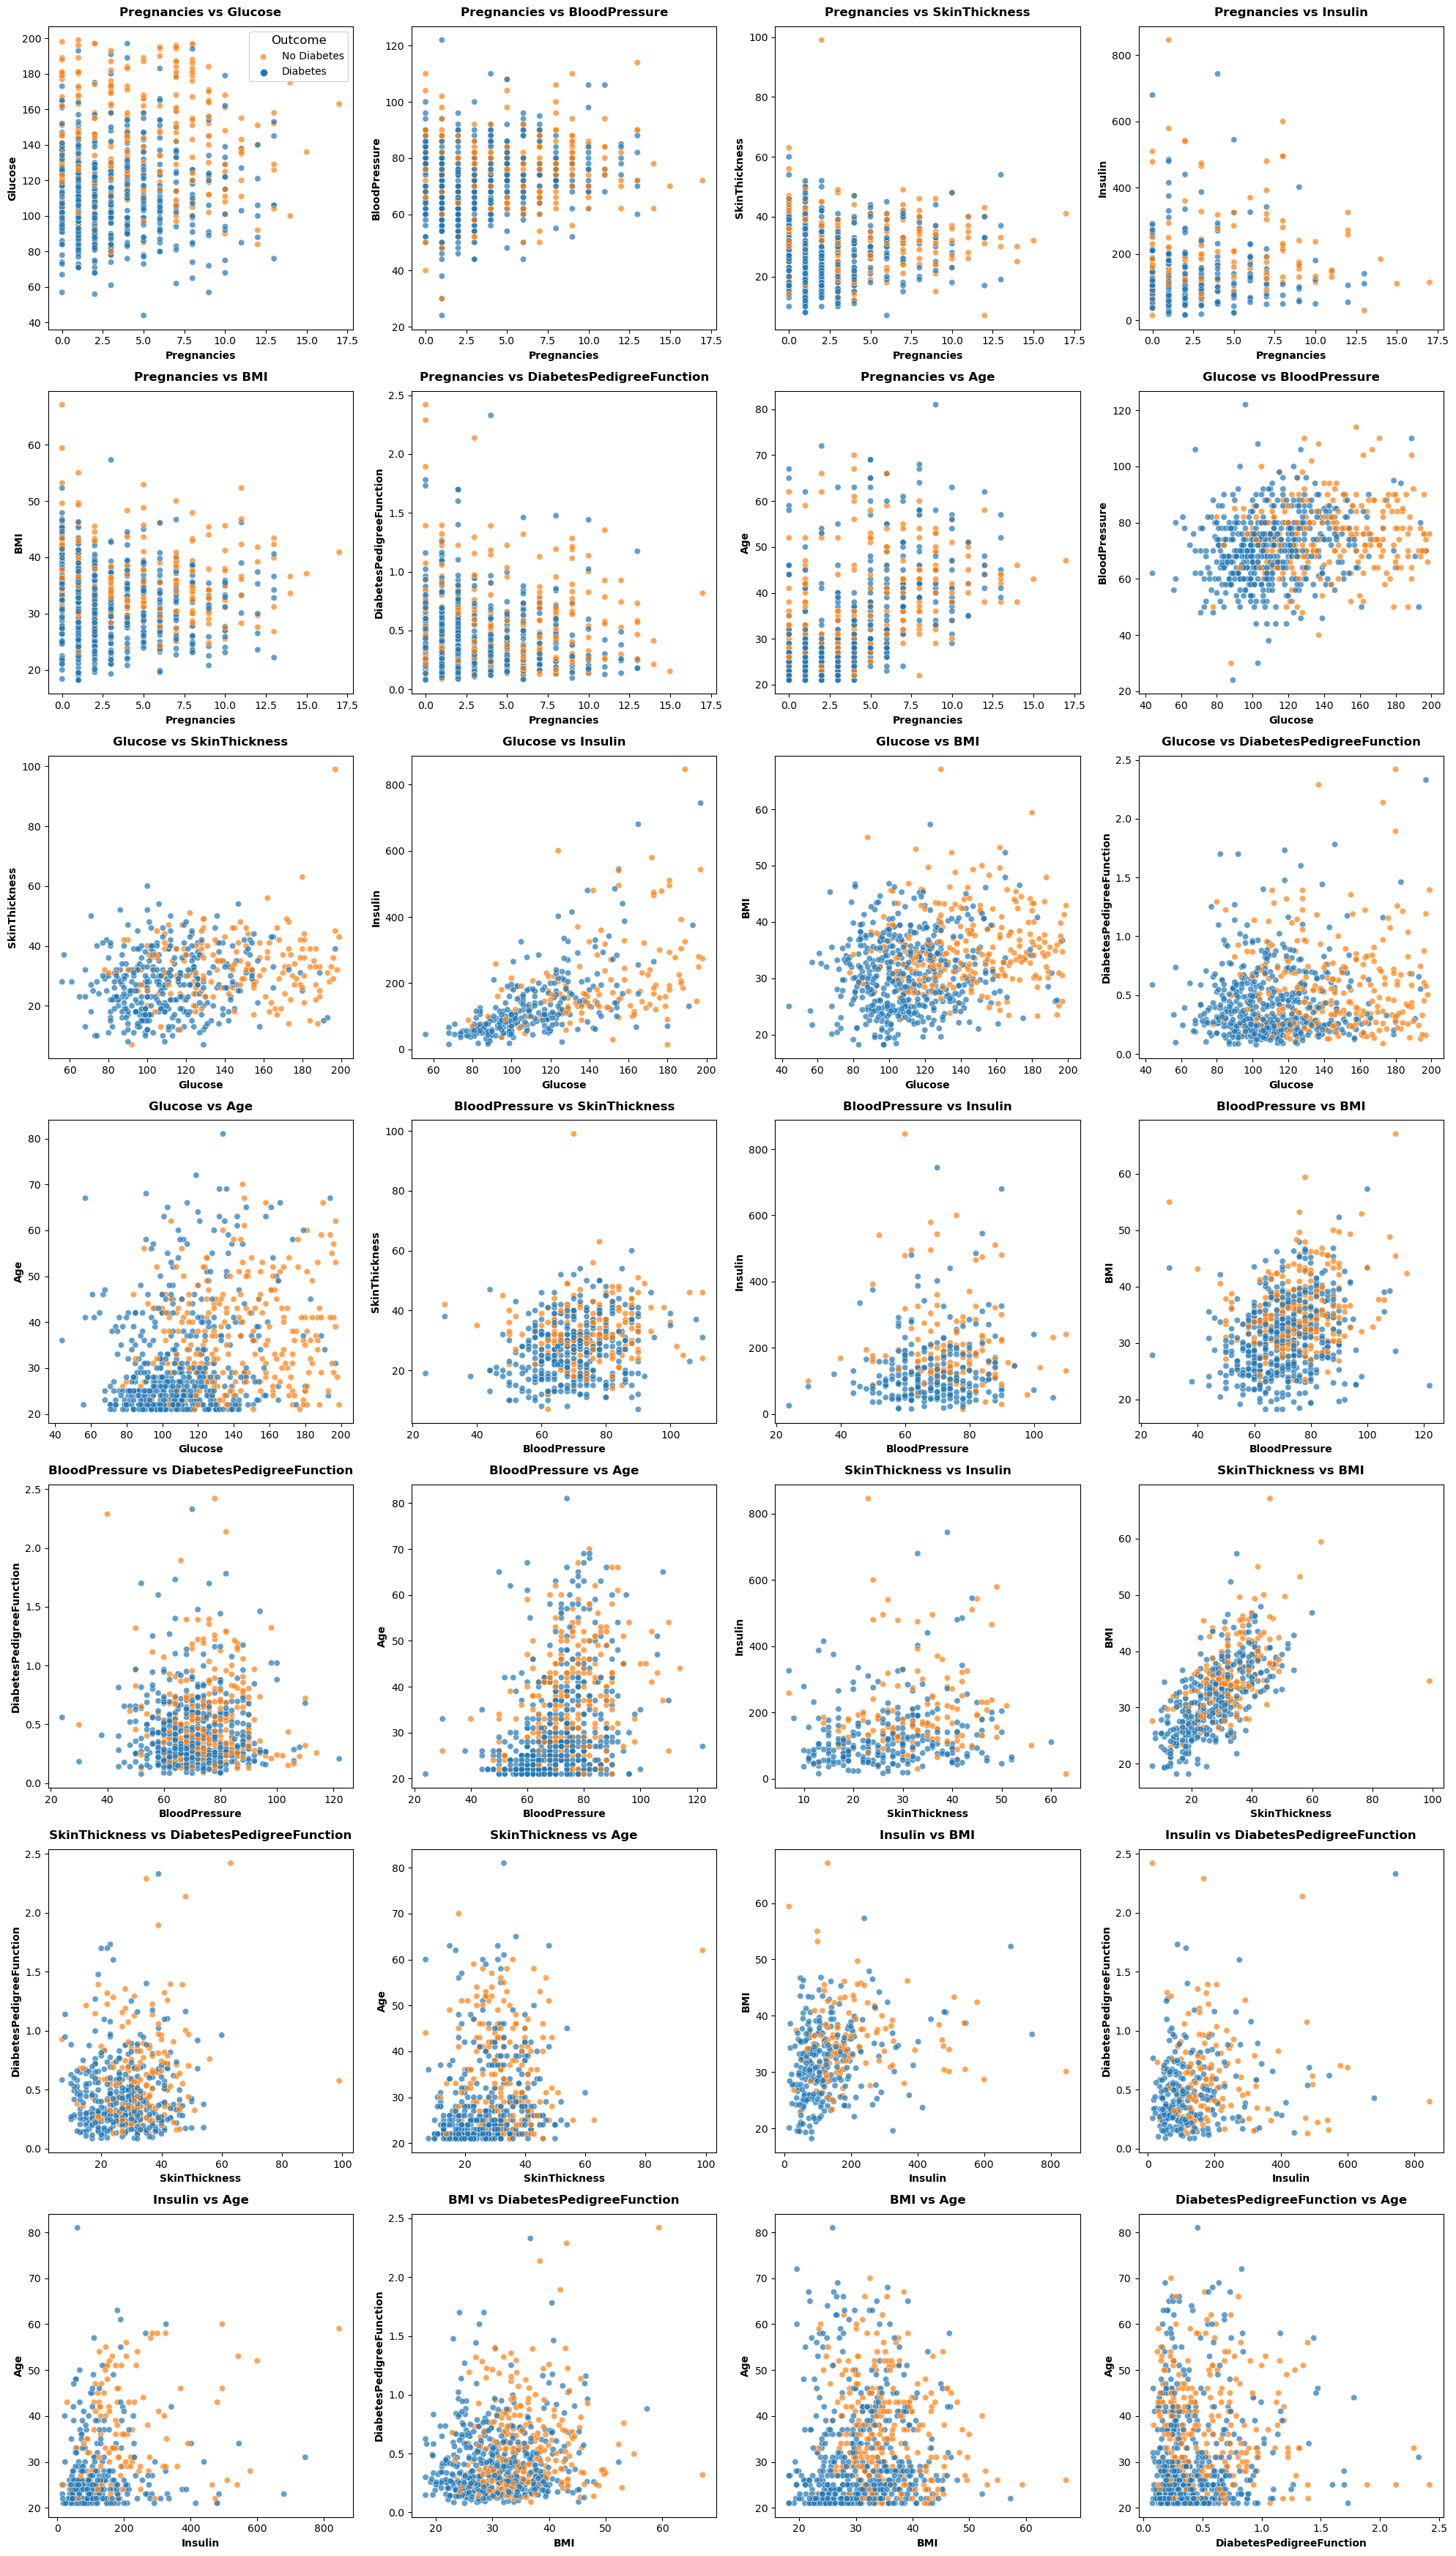

In [10]:
from itertools import combinations

palette = {0: "#1f77b4", 1: "#ff7f0e"}


def plot_scatter_grid(dataframe, variables, hue_var):
    num_plots = len(variables)
    num_cols = 4
    num_rows = (num_plots + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))
    axes = axes.flatten()

    for i, var in enumerate(variables):
        sns.scatterplot(
            x=var[0],
            y=var[1],
            hue=hue_var,
            palette=palette,
            data=dataframe,
            ax=axes[i],
            alpha=0.7,
        )
        axes[i].set_title(
            f"{var[0]} vs {var[1]}", fontsize=12, fontweight="bold", pad=10
        )
        axes[i].set_xlabel(var[0], fontsize=10, fontweight="bold")
        axes[i].set_ylabel(var[1], fontsize=10, fontweight="bold")
        if i == 0:
            axes[i].legend(
                title="Outcome",
                labels=["No Diabetes", "Diabetes"],
                fontsize=10,
                title_fontsize=12,
            )
        else:
            axes[i].legend().remove()

    for j in range(num_plots, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


comb = [col for col in df.columns if col not in "Outcome"]
variables = list(combinations(comb, 2))

plot_scatter_grid(df, variables, "Outcome")

In [11]:
# Calculates the lower and upper thresholds to identify outliers for a given column in the dataframe


def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


# Checks if a specific column in the dataframe contains any outliers based on calculated thresholds


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[
        (dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)
    ].any(axis=None):
        return True
    else:
        return False


# Checks all columns in the dataframe for the presence of outliers and returns a dictionary with the results


def check_all_columns_outliers(dataframe):
    results = {}
    for col in dataframe.columns:
        results[col] = check_outlier(dataframe, col)
    return results

In [12]:
outlier_results = check_all_columns_outliers(df)
for col, has_outliers in outlier_results.items():
    print(f"{col}: {'Outliers present' if has_outliers else 'No outliers'}")

Pregnancies: No outliers
Glucose: No outliers
BloodPressure: No outliers
SkinThickness: Outliers present
Insulin: No outliers
BMI: No outliers
DiabetesPedigreeFunction: No outliers
Age: No outliers
Outcome: No outliers


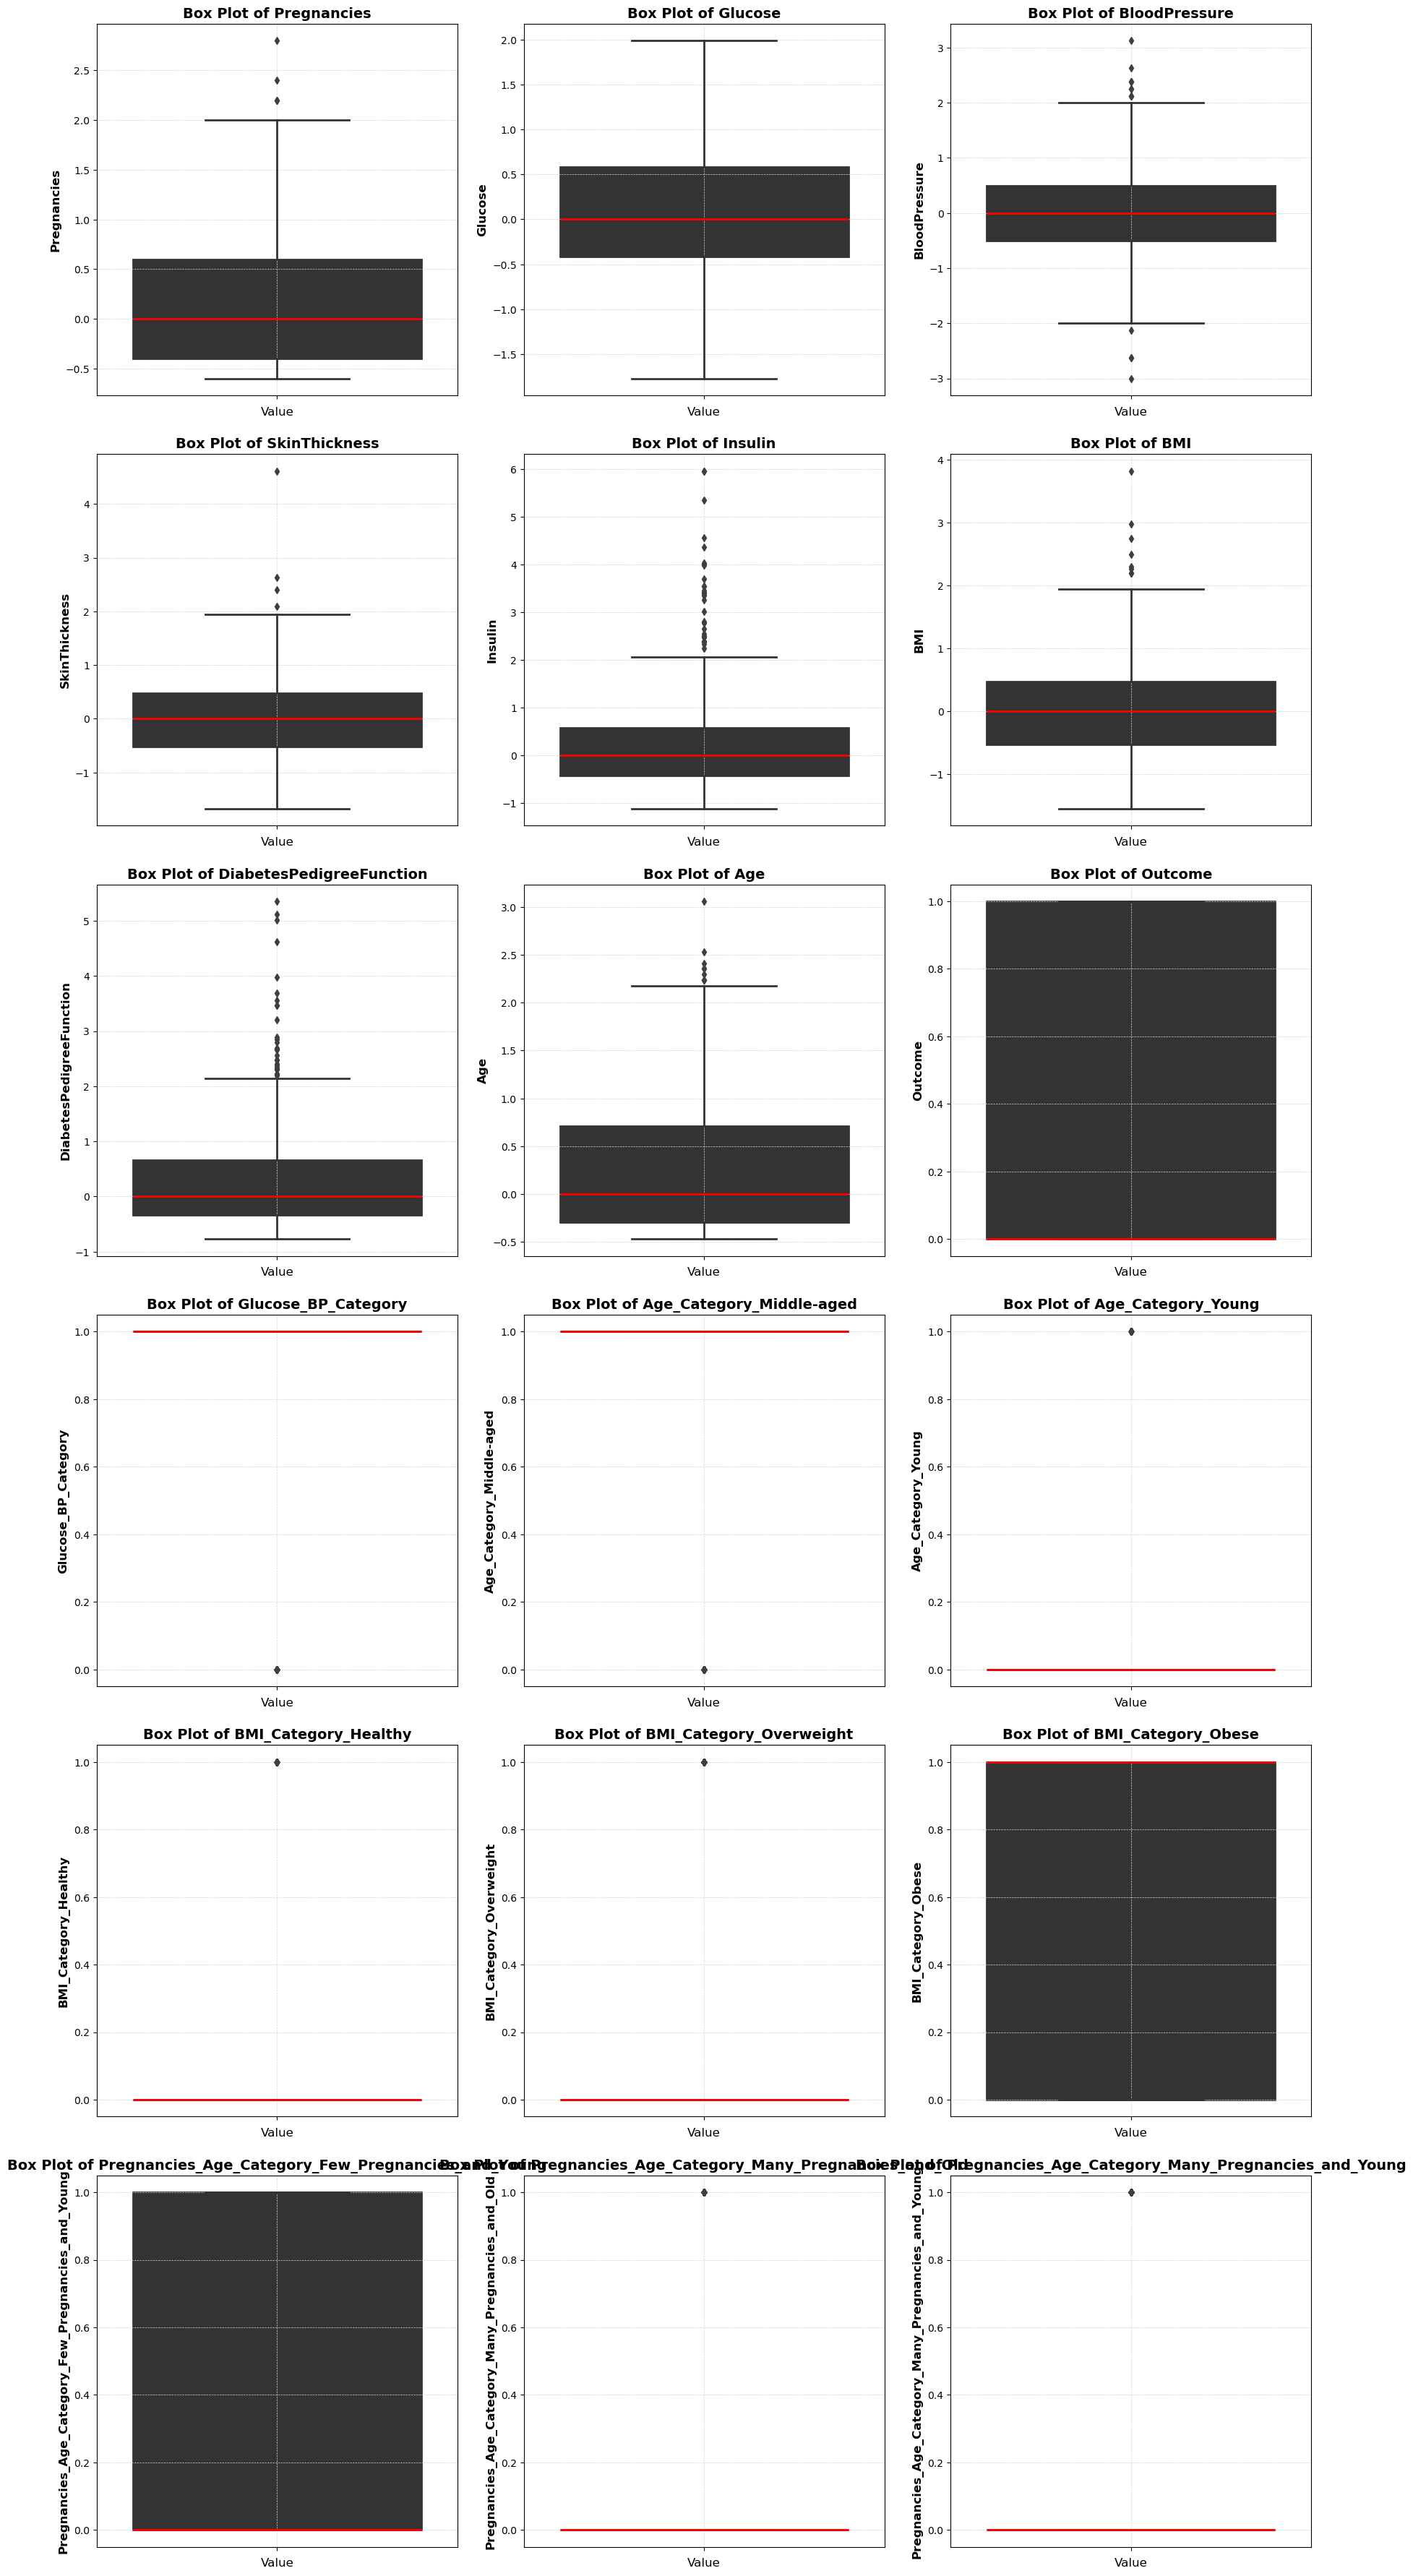

In [48]:
def plot_boxplot_per_variable(dataframe):
    numeric_cols = dataframe.select_dtypes(include=["int64", "float64"]).columns
    num_plots = len(numeric_cols)
    num_cols = 3
    num_rows = (num_plots + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 6))
    axes = axes.flatten()

    boxprops = dict(linewidth=2, color="#333333")
    whiskerprops = dict(linewidth=2, color="#333333")
    capprops = dict(linewidth=2, color="#333333")
    medianprops = dict(linewidth=2, color="r")

    for i, col in enumerate(numeric_cols):
        sns.boxplot(
            y=dataframe[col],
            ax=axes[i],
            orient="h",
            boxprops=boxprops,
            whiskerprops=whiskerprops,
            capprops=capprops,
            medianprops=medianprops,
        )
        axes[i].set_title(f"Box Plot of {col}", fontsize=14, fontweight="bold")
        axes[i].set_xlabel("Value", fontsize=12)
        axes[i].set_ylabel(col, fontsize=12, fontweight="bold")
        axes[i].tick_params(axis="both", labelsize=10)
        axes[i].grid(True, linestyle="--", linewidth=0.5, color="lightgray")

    for j in range(num_plots, len(axes)):
        axes[j].axis("off")

    plt.tight_layout(pad=2.0)
    plt.show()


plot_boxplot_per_variable(df)

In [14]:
def missing_values_table(dataframe, nan_name=False, plot=False):
    nan_columns = [
        col for col in dataframe.columns if dataframe[col].isnull().sum() > 0
    ]
    n_miss = dataframe[nan_columns].isnull().sum().sort_values(ascending=False)
    ratio = (
        dataframe[nan_columns].isnull().sum() / dataframe.shape[0] * 100
    ).sort_values(ascending=False)
    missing_df = pd.concat(
        [n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss", "ratio"]
    )
    print(missing_df, end="\n")

    if plot:
        plt.figure(figsize=(10, 8))
        bars = plt.bar(missing_df.index, missing_df["ratio"], color="skyblue")
        plt.xlabel("Features")
        plt.ylabel("Percentage of Missing Values")
        plt.title("Missing Values by Feature")

        for bar in bars:
            yval = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                yval,
                f"{yval:.2f}%",
                ha="center",
                va="bottom",
                fontsize=10,
            )

        plt.xticks(rotation=90, fontsize=8)
        plt.yticks(fontsize=8)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    if nan_name:
        return nan_columns

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650


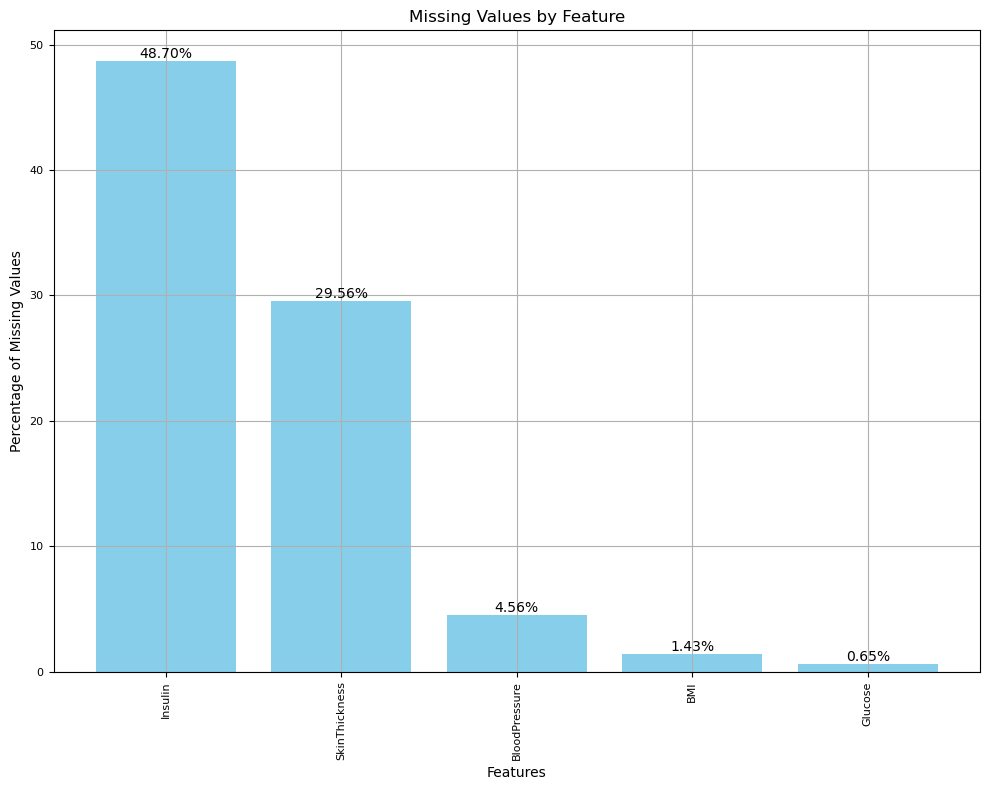

In [15]:
nan_columns = missing_values_table(df, nan_name=True, plot=True)

#### **Handling the Outliers**


In [16]:
from sklearn.impute import KNNImputer

columns_to_fill = ["Insulin", "SkinThickness", "BloodPressure", "BMI", "Glucose"]
data_to_fill = df[columns_to_fill]

imputer = KNNImputer(n_neighbors=5)

df[columns_to_fill] = imputer.fit_transform(data_to_fill)

missing_values = df[columns_to_fill].isnull().sum()
print("Filled missing values:")
print(missing_values)

Filled missing values:
Insulin          0
SkinThickness    0
BloodPressure    0
BMI              0
Glucose          0
dtype: int64


In [17]:
def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


variables_to_process = [col for col in df.columns if col != "Outcome"]

for col in df.columns:
    print(f"{col}: {check_outlier(df, col)}")
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

Pregnancies: False
Glucose: False
BloodPressure: False
SkinThickness: True
Insulin: True
BMI: False
DiabetesPedigreeFunction: False
Age: False
Outcome: False


In [18]:
check_all_columns_outliers(df)

{'Pregnancies': False,
 'Glucose': False,
 'BloodPressure': False,
 'SkinThickness': False,
 'Insulin': False,
 'BMI': False,
 'DiabetesPedigreeFunction': False,
 'Age': False,
 'Outcome': False}

#### **Adding New Categorical Columns**


In [19]:
conditions = [df["Age"] <= 21, (df["Age"] > 21) & (df["Age"] < 50), df["Age"] >= 50]
categories = ["Young", "Middle-aged", "Elderly"]

df["Age_Category"] = np.select(conditions, categories)

In [20]:
bins = [0, 18.5, 24.9, 29.9, 100]
labels = ["Underweight", "Healthy", "Overweight", "Obese"]

df["BMI_Category"] = pd.cut(x=df["BMI"], bins=bins, labels=labels)

In [21]:
conditions = [
    (df["Pregnancies"] > 3) & (df["Age"] < 40),
    (df["Pregnancies"] <= 3) & (df["Age"] >= 40),
    (df["Pregnancies"] <= 3) & (df["Age"] < 40),
    (df["Pregnancies"] > 3) & (df["Age"] >= 40),
]

categories = [
    "Many_Pregnancies_and_Young",
    "Few_Pregnancies_and_Old",
    "Few_Pregnancies_and_Young",
    "Many_Pregnancies_and_Old",
]

df["Pregnancies_Age_Category"] = np.select(conditions, categories)

In [22]:
conditions = [
    (df["Glucose"] > 150) & (df["BloodPressure"] < 80),
    (df["Glucose"] <= 150) & (df["BloodPressure"] >= 80),
]

df["Glucose_BP_Category"] = pd.Series(
    pd.cut(
        df["Glucose"],
        bins=[-1, 150, 300],
        labels=["Normal_Glucose_and_BP", "High_Glucose_and_Low_BP"],
    )
)

In [23]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age_Category,BMI_Category,Pregnancies_Age_Category,Glucose_BP_Category
0,6,148.000,72.000,35.000,209.000,33.600,0.627,50,1,Elderly,Obese,Many_Pregnancies_and_Old,Normal_Glucose_and_BP
1,1,85.000,66.000,29.000,73.000,26.600,0.351,31,0,Middle-aged,Overweight,Few_Pregnancies_and_Young,Normal_Glucose_and_BP
2,8,183.000,64.000,29.400,383.200,23.300,0.672,32,1,Middle-aged,Healthy,Many_Pregnancies_and_Young,High_Glucose_and_Low_BP
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,Young,Overweight,Few_Pregnancies_and_Young,Normal_Glucose_and_BP
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,Middle-aged,Obese,Few_Pregnancies_and_Young,Normal_Glucose_and_BP
5,5,116.000,74.000,16.600,87.400,25.600,0.201,30,0,Middle-aged,Overweight,Many_Pregnancies_and_Young,Normal_Glucose_and_BP
6,3,78.000,50.000,32.000,88.000,31.000,0.248,26,1,Middle-aged,Obese,Few_Pregnancies_and_Young,Normal_Glucose_and_BP
7,10,115.000,77.600,29.000,133.400,35.300,0.134,29,0,Middle-aged,Obese,Many_Pregnancies_and_Young,Normal_Glucose_and_BP
8,2,197.000,70.000,45.000,543.000,30.500,0.158,53,1,Elderly,Obese,Few_Pregnancies_and_Old,High_Glucose_and_Low_BP
9,8,125.000,96.000,41.200,199.800,34.160,0.232,54,1,Elderly,Obese,Many_Pregnancies_and_Old,Normal_Glucose_and_BP


In [24]:
check_df(df)

--------------------------------SHAPE---------------------------------
(768, 13)
---------------------------------INFO---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Pregnancies               768 non-null    int64   
 1   Glucose                   768 non-null    float64 
 2   BloodPressure             768 non-null    float64 
 3   SkinThickness             768 non-null    float64 
 4   Insulin                   768 non-null    float64 
 5   BMI                       768 non-null    float64 
 6   DiabetesPedigreeFunction  768 non-null    float64 
 7   Age                       768 non-null    int64   
 8   Outcome                   768 non-null    int64   
 9   Age_Category              768 non-null    object  
 10  BMI_Category              768 non-null    category
 11  Pregnancie

In [25]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [
        col
        for col in dataframe.columns
        if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"
    ]
    cat_but_car = [
        col
        for col in dataframe.columns
        if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"
    ]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")
    return cat_cols, num_cols


cat_cols, num_cols = grab_col_names(df)
cat_cols

Observations: 768
Variables: 13
cat_cols: 5
num_cols: 8
cat_but_car: 0
num_but_cat: 3


['Age_Category',
 'Pregnancies_Age_Category',
 'Outcome',
 'BMI_Category',
 'Glucose_BP_Category']

#### **Encoding the Features**


In [26]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe


binary_cols = [
    col
    for col in df.columns
    if df[col].dtype not in [int, float] and df[col].nunique() == 2
]
binary_cols

['Outcome', 'Glucose_BP_Category']

In [27]:
for col in binary_cols:
    df = label_encoder(df, col)

In [28]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age_Category,BMI_Category,Pregnancies_Age_Category,Glucose_BP_Category
0,6,148.000,72.000,35.000,209.000,33.600,0.627,50,1,Elderly,Obese,Many_Pregnancies_and_Old,1
1,1,85.000,66.000,29.000,73.000,26.600,0.351,31,0,Middle-aged,Overweight,Few_Pregnancies_and_Young,1
2,8,183.000,64.000,29.400,383.200,23.300,0.672,32,1,Middle-aged,Healthy,Many_Pregnancies_and_Young,0
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,Young,Overweight,Few_Pregnancies_and_Young,1
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,Middle-aged,Obese,Few_Pregnancies_and_Young,1
5,5,116.000,74.000,16.600,87.400,25.600,0.201,30,0,Middle-aged,Overweight,Many_Pregnancies_and_Young,1
6,3,78.000,50.000,32.000,88.000,31.000,0.248,26,1,Middle-aged,Obese,Few_Pregnancies_and_Young,1
7,10,115.000,77.600,29.000,133.400,35.300,0.134,29,0,Middle-aged,Obese,Many_Pregnancies_and_Young,1
8,2,197.000,70.000,45.000,543.000,30.500,0.158,53,1,Elderly,Obese,Few_Pregnancies_and_Old,0
9,8,125.000,96.000,41.200,199.800,34.160,0.232,54,1,Elderly,Obese,Many_Pregnancies_and_Old,1


In [29]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(
        dataframe, columns=categorical_cols, drop_first=drop_first
    )
    dataframe = dataframe.applymap(
        lambda x: 1 if x is True else (0 if x is False else x)
    )
    return dataframe


ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

df = one_hot_encoder(df, ohe_cols)

In [30]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Glucose_BP_Category,Age_Category_Middle-aged,Age_Category_Young,BMI_Category_Healthy,BMI_Category_Overweight,BMI_Category_Obese,Pregnancies_Age_Category_Few_Pregnancies_and_Young,Pregnancies_Age_Category_Many_Pregnancies_and_Old,Pregnancies_Age_Category_Many_Pregnancies_and_Young
0,6,148.000,72.000,35.000,209.000,33.600,0.627,50,1,1,0,0,0,0,1,0,1,0
1,1,85.000,66.000,29.000,73.000,26.600,0.351,31,0,1,1,0,0,1,0,1,0,0
2,8,183.000,64.000,29.400,383.200,23.300,0.672,32,1,0,1,0,1,0,0,0,0,1
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,1,0,1,0,1,0,1,0,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,1,1,0,0,0,1,1,0,0
5,5,116.000,74.000,16.600,87.400,25.600,0.201,30,0,1,1,0,0,1,0,0,0,1
6,3,78.000,50.000,32.000,88.000,31.000,0.248,26,1,1,1,0,0,0,1,1,0,0
7,10,115.000,77.600,29.000,133.400,35.300,0.134,29,0,1,1,0,0,0,1,0,0,1
8,2,197.000,70.000,45.000,543.000,30.500,0.158,53,1,0,0,0,0,0,1,0,0,0
9,8,125.000,96.000,41.200,199.800,34.160,0.232,54,1,1,0,0,0,0,1,0,1,0


#### **Scaling the Data**


In [31]:
scaler = RobustScaler()

num_cols

df[num_cols] = scaler.fit_transform(df[num_cols])

In [32]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Glucose_BP_Category,Age_Category_Middle-aged,Age_Category_Young,BMI_Category_Healthy,BMI_Category_Overweight,BMI_Category_Obese,Pregnancies_Age_Category_Few_Pregnancies_and_Young,Pregnancies_Age_Category_Many_Pregnancies_and_Old,Pregnancies_Age_Category_Many_Pregnancies_and_Young
0,0.600,0.752,0.000,0.477,0.773,0.143,0.665,1.235,1,1,0,0,0,0,1,0,1,0
1,-0.400,-0.776,-0.375,0.015,-0.546,-0.626,-0.056,0.118,0,1,1,0,0,1,0,1,0,0
2,1.000,1.600,-0.500,0.046,2.464,-0.989,0.783,0.176,1,0,1,0,1,0,0,0,0,1
3,-0.400,-0.679,-0.375,-0.446,-0.343,-0.462,-0.537,-0.471,0,1,0,1,0,1,0,1,0,0
4,-0.600,0.485,-2.000,0.477,0.376,1.187,5.008,0.235,1,1,1,0,0,0,1,1,0,0
5,0.400,-0.024,0.125,-0.938,-0.407,-0.736,-0.448,0.059,0,1,1,0,0,1,0,0,0,1
6,0.000,-0.945,-1.375,0.246,-0.401,-0.143,-0.325,-0.176,1,1,1,0,0,0,1,1,0,0
7,1.400,-0.048,0.350,0.015,0.040,0.330,-0.624,0.000,0,1,1,0,0,0,1,0,0,1
8,-0.200,1.939,-0.125,1.246,4.015,-0.198,-0.561,1.412,1,0,0,0,0,0,1,0,0,0
9,1.000,0.194,1.500,0.954,0.684,0.204,-0.367,1.471,1,1,0,0,0,0,1,0,1,0


#### **Splitting the data**


In [33]:
y = df["Outcome"]
X = df.drop("Outcome", axis=1)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=17
)

In [34]:
def eval_model(pred_outcome, model, model_name):
    accuracy = accuracy_score(y_test, pred_outcome)
    precision = precision_score(y_test, pred_outcome)
    recall = recall_score(y_test, pred_outcome)
    f1 = f1_score(y_test, pred_outcome)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(model_name.center(70, "-"))
    print(f"Accuracy: {round(accuracy, 4)}")
    print("\n")
    print(f"Precision: {round(precision, 4)}")
    print("\n")
    print(f"Recall: {round(recall, 4)}")
    print("\n")
    print(f"F1-score: {round(f1, 4)}")
    print("\n")
    print(f"ROC AUC: {round(roc_auc, 4)}")
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
    }

#### **Random Forest Classifier**


In [35]:
rf_model = RandomForestClassifier(random_state=46)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=46)

#### **RF Evaluation**


In [36]:
rf_pred = rf_model.predict(X_test)
rf_metrics = eval_model(rf_pred, rf_model, "RF")

----------------------------------RF----------------------------------
Accuracy: 0.7792


Precision: 0.6974


Recall: 0.6543


F1-score: 0.6752


ROC AUC: 0.8523


In [37]:
from sklearn.metrics import confusion_matrix

rf_conf = confusion_matrix(y_test, rf_pred)
rf_conf

array([[127,  23],
       [ 28,  53]], dtype=int64)

#### **Checking the Most Import Features**


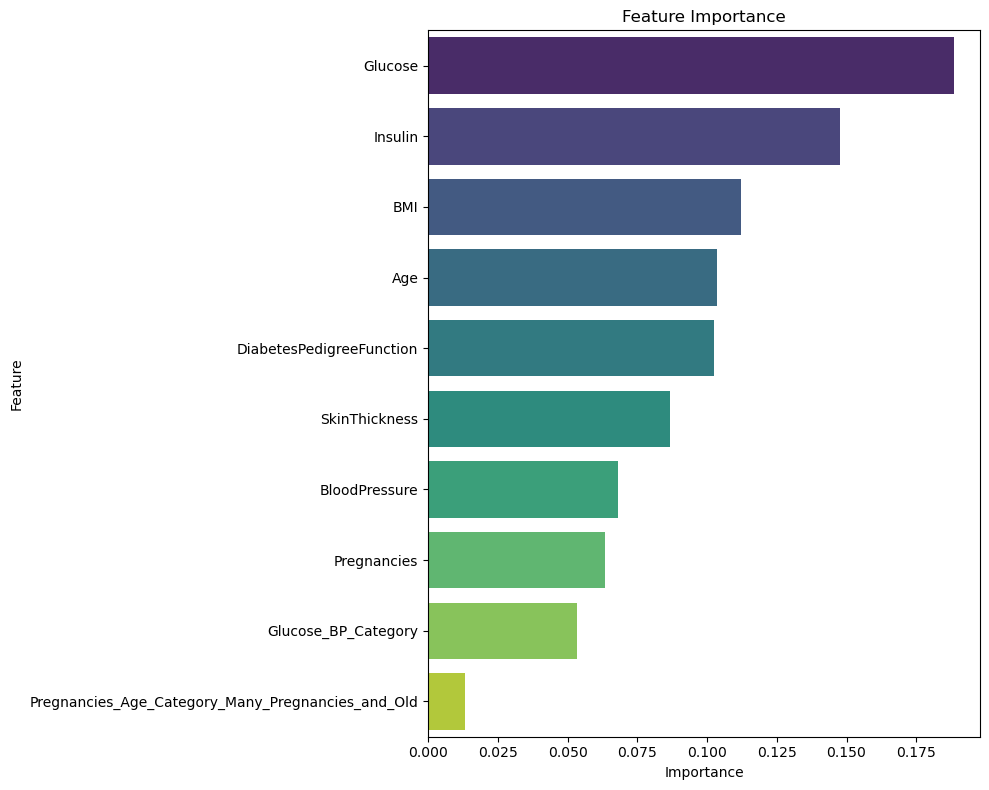

In [38]:
def plot_feature_importance(model, features):
    feature_imp = pd.DataFrame(
        {"Feature": features.columns, "Importance": model.feature_importances_}
    )
    feature_imp = feature_imp.sort_values(by="Importance", ascending=False).head(10)
    plt.figure(figsize=(10, 8))
    sns.barplot(x="Importance", y="Feature", data=feature_imp, palette="viridis")
    plt.title("Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


plot_feature_importance(rf_model, X_train)

In [39]:
lr_model = LogisticRegression(random_state=46)
lr_model.fit(X_train, y_train)

LogisticRegression(random_state=46)

In [40]:
lr_pred = lr_model.predict(X_test)
lr_metrics = eval_model(lr_pred, lr_model, "LR")

----------------------------------LR----------------------------------
Accuracy: 0.7662


Precision: 0.7077


Recall: 0.5679


F1-score: 0.6301


ROC AUC: 0.8427


In [41]:
lr_conf = confusion_matrix(y_test, lr_pred)
lr_conf

array([[131,  19],
       [ 35,  46]], dtype=int64)

In [42]:
import math
n = math.floor(math.sqrt(len(df)))
knn_model = KNeighborsClassifier(n_neighbors=n)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=27)

In [43]:
knn_pred = knn_model.predict(X_test)
knn_metrics = eval_model(knn_pred, knn_model, "KNN")

---------------------------------KNN----------------------------------
Accuracy: 0.7619


Precision: 0.7167


Recall: 0.5309


F1-score: 0.6099


ROC AUC: 0.8161


In [44]:
knn_conf = confusion_matrix(y_test, knn_pred)
knn_conf

array([[133,  17],
       [ 38,  43]], dtype=int64)

In [45]:
metrics = {
    "model": ["KNN", "RF", "LR"],
    "accuracy": [
        knn_metrics["accuracy"],
        rf_metrics["accuracy"],
        lr_metrics["accuracy"],
    ],
    "precision": [
        knn_metrics["precision"],
        rf_metrics["precision"],
        lr_metrics["precision"],
    ],
    "recall": [knn_metrics["recall"], rf_metrics["recall"], lr_metrics["recall"]],
    "f1": [knn_metrics["f1"], rf_metrics["f1"], lr_metrics["f1"]],
    "roc_auc": [knn_metrics["roc_auc"], rf_metrics["roc_auc"], lr_metrics["roc_auc"]],
}

In [46]:
metrics = pd.DataFrame(metrics)
metrics

,model,accuracy,precision,recall,f1,roc_auc
0,KNN,0.762,0.717,0.531,0.610,0.816
1,RF,0.779,0.697,0.654,0.675,0.852
2,LR,0.766,0.708,0.568,0.630,0.843


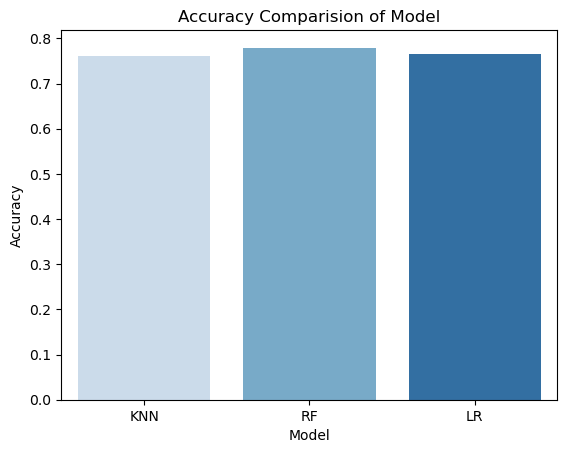

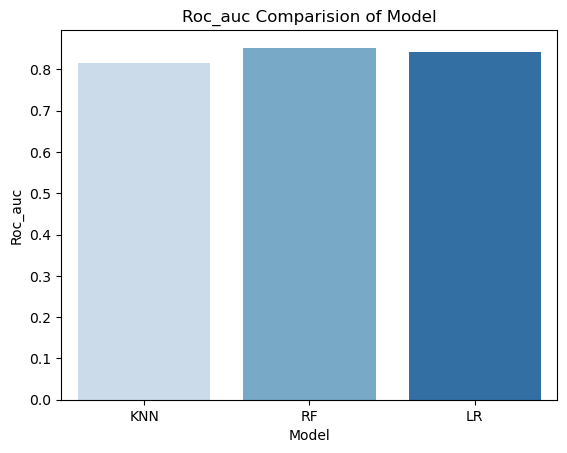

In [47]:
for metric in enumerate(["accuracy", "roc_auc"]):
    sns.barplot(x="model", y=metric[1], data=metrics, palette="Blues")
    plt.title(f"{metric[1].capitalize()} Comparision of Model")
    plt.xlabel("Model")
    plt.ylabel(metric[1].capitalize())
    plt.show()